In [41]:
import sys
import pandas as pd
from pathlib import Path
project_root = Path("..").resolve()
sys.path.append(str(project_root))
from ml_toolbox import HilbertEnvelopeAnalyzer, EnvelopeConfig, DataLoader, WindowConfig, WindowExtractor


# Load data and create windows
dataset_path = Path("../data_set")
data_loader = DataLoader(dataset_path)

frequency = '10hz'
sensor_type = 'current'
load = 'no_load'
sampling_rate = 10000

healthy, healthy_metadata = data_loader.load_batch(
    condition='system_misalignment', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

# Load faulty data for comparison
faulty_data, faulty_metadata = data_loader.load_batch(
    condition='misalignment', 
    load=load, 
    sensor_type=sensor_type, 
    frequency=frequency,
    apply_filter=False,
    max_workers=1
)

n_healthy = 16384
n_faulty = 16384

# Create windows
overlap_ratio = 0.5
healthy_step_size = int(n_healthy * (1 - overlap_ratio))
healthy_window_config = WindowConfig(window_size=n_healthy, 
                             step_size=healthy_step_size,
                             overlap_ratio=overlap_ratio)
healthy_extractor = WindowExtractor(healthy_window_config)
healthy_windows, healthy_win_metadata = healthy_extractor.extract_windows(healthy[0], healthy_metadata[0])

faulty_step_size = int(n_faulty * (1 - overlap_ratio))
faulty_window_config = WindowConfig(
    window_size=n_faulty,
    step_size=faulty_step_size,
    overlap_ratio=overlap_ratio
)

faulty_extractor = WindowExtractor(faulty_window_config)
faulty_windows, faulty_win_metadata = faulty_extractor.extract_windows(faulty_data[0], faulty_metadata[0])

h_w = healthy_windows[0]
h_ch1 = h_w[:, 0]
h_ch2 = h_w[:, 1]

f_w = faulty_windows[0]
f_ch1 = f_w[:, 0]
f_ch2 = f_w[:, 1]

# carrier freqs: 1670, 3330
carrier_freq = 1679
env_conf = EnvelopeConfig(
    bandpass_low=carrier_freq - 50,
    bandpass_high=carrier_freq + 50,
    lowpass_cutoff=200.0,
    filter_order=4,
    decimation_factor=5,
    sampling_rate=10000 # current fs
)

analyzer = HilbertEnvelopeAnalyzer(env_conf)

h_stages = analyzer.extract_envelope_with_stages(h_ch1, return_stages=True)
f_stages = analyzer.extract_envelope_with_stages(f_ch1, return_stages=True)




INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files
INFO:ml_toolbox.data_loader.data_loader:Loading 3 files with 1 workers
INFO:ml_toolbox.data_loader.data_loader:Successfully loaded 3 files


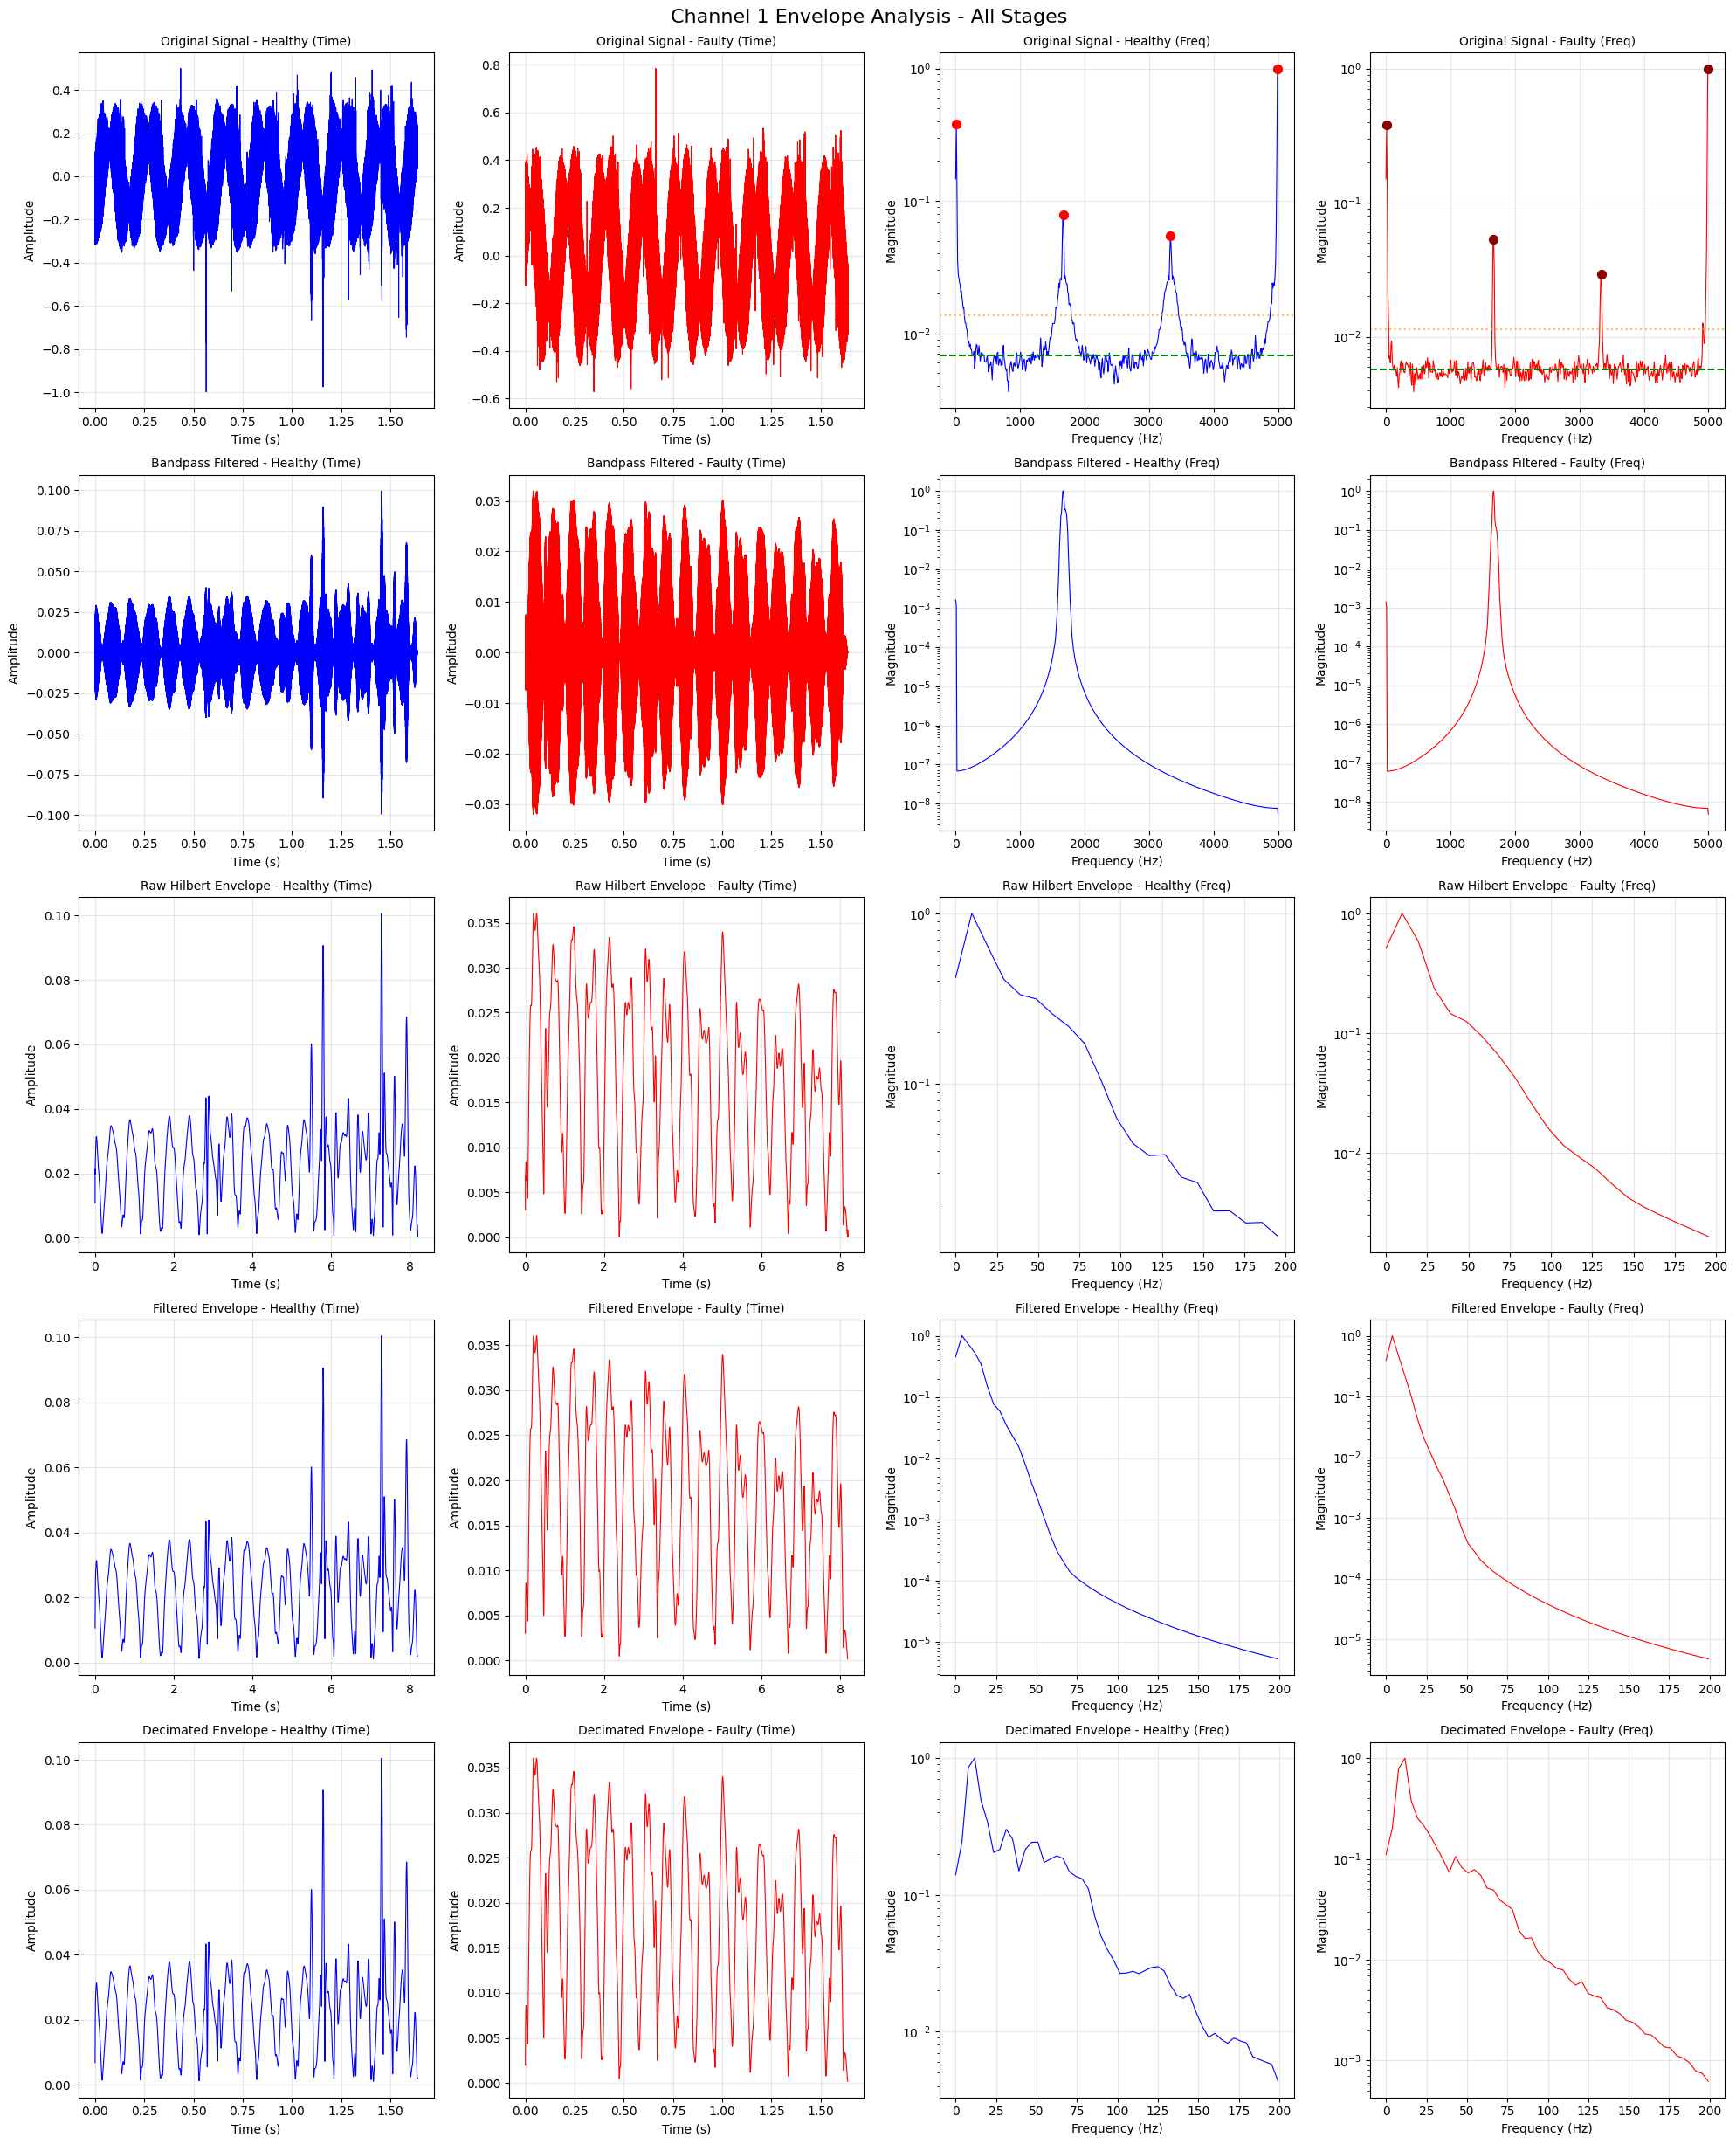

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive plots for all stages
def plot_envelope_analysis(stages_healthy, stages_faulty, analyzer_config, title_prefix=""):
    """Plot all envelope analysis stages in time and frequency domains"""
    
    # Create figure with subplots
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))
    fig.suptitle(f'{title_prefix} Envelope Analysis - All Stages', fontsize=16, y=0.98)
    
    # Stage names and their corresponding data
    stage_names = ['original', 'bandpass_filtered', 'envelope_raw', 'envelope_filtered', 'envelope_decimated']
    stage_titles = ['Original Signal', 'Bandpass Filtered', 'Raw Hilbert Envelope', 'Filtered Envelope', 'Decimated Envelope']
    
    for i, (stage_name, stage_title) in enumerate(zip(stage_names, stage_titles)):
        # Get data for current stage
        h_data = stages_healthy[stage_name]
        f_data = stages_faulty[stage_name]
        
        # Determine sampling rate for this stage
        if 'envelope' in stage_name:
            fs = analyzer_config.envelope_fs
        else:
            fs = analyzer_config.sampling_rate
        
        # Create time vectors
        h_time = np.arange(len(h_data)) / fs
        f_time = np.arange(len(f_data)) / fs
        
        # Time domain plots - Healthy
        axes[i, 0].plot(h_time, h_data, 'b-', linewidth=0.8)
        axes[i, 0].set_title(f'{stage_title} - Healthy (Time)', fontsize=10)
        axes[i, 0].set_xlabel('Time (s)')
        axes[i, 0].set_ylabel('Amplitude')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Time domain plots - Faulty
        axes[i, 1].plot(f_time, f_data, 'r-', linewidth=0.8)
        axes[i, 1].set_title(f'{stage_title} - Faulty (Time)', fontsize=10)
        axes[i, 1].set_xlabel('Time (s)')
        axes[i, 1].set_ylabel('Amplitude')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Frequency domain analysis - Healthy
        nperseg = 512 if stage_name == 'envelope_filtered' or stage_name == 'envelope_decimated' else 1024
        h_spectrum = analyzer.compute_fft_spectrum(stages_healthy['original'], stage_name, nperseg = nperseg)

        h_freqs = h_spectrum['freqs']
        h_magnitude = h_spectrum['magnitude']
        
        # Plot spectrum up to reasonable frequency limit
        freq_limit = min(fs/2, 200) if 'envelope' in stage_name else min(fs/2, 5000)
        freq_mask = h_freqs <= freq_limit
        
        axes[i, 2].plot(h_freqs[freq_mask], h_magnitude[freq_mask], 'b-', linewidth=0.8)
        axes[i, 2].set_title(f'{stage_title} - Healthy (Freq)', fontsize=10)
        axes[i, 2].set_xlabel('Frequency (Hz)')
        axes[i, 2].set_ylabel('Magnitude')
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].set_yscale('log')
        
        # Frequency domain analysis - Faulty
        f_spectrum = analyzer.compute_fft_spectrum(stages_faulty['original'], stage_name, nperseg=nperseg)
        f_freqs = f_spectrum['freqs']
        f_magnitude = f_spectrum['magnitude']
        
        freq_mask_f = f_freqs <= freq_limit
        
        axes[i, 3].plot(f_freqs[freq_mask_f], f_magnitude[freq_mask_f], 'r-', linewidth=0.8)
        axes[i, 3].set_title(f'{stage_title} - Faulty (Freq)', fontsize=10)
        axes[i, 3].set_xlabel('Frequency (Hz)')
        axes[i, 3].set_ylabel('Magnitude')
        axes[i, 3].grid(True, alpha=0.3)
        axes[i, 3].set_yscale('log')

        if stage_name == 'original':
            h_median = np.median(h_magnitude)
            axes[i, 2].axhline(y=h_median, color='g', linestyle='--')
            axes[i, 2].axhline(y=h_median*2, color='orange', linestyle=':', alpha=0.7)
            h_peaks = analyzer.find_spectral_peaks(h_spectrum, num_peaks= 5, distance=5, height=h_median*2, prominence=h_median)
            axes[i, 2].scatter(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'], 
                          color='red', s=50, zorder=5, label='Detected Peaks')
            f_median = np.median(f_magnitude)
            axes[i, 3].axhline(y=f_median, color='g', linestyle='--')
            axes[i, 3].axhline(y=f_median*2, color='orange', linestyle=':', alpha=0.7)
            f_peaks = analyzer.find_spectral_peaks(f_spectrum, num_peaks=5, distance=5, height=f_median*2, prominence=f_median)
            axes[i, 3].scatter(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'],
                               color='darkred', s=50, zorder=5, label='Detected Peaks')
            if len(h_peaks['peak_freqs']) > 0:
                print("Healthy - Detected Peaks:")
                for idx, (freq, mag) in enumerate(zip(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'])):
                    print(f"  Peak {idx+1}: {freq:.2f} Hz, magnitude: {mag:.6f}")

            if len(f_peaks['peak_freqs']) > 0:
                print("Faulty - Detected Peaks:")
                for idx, (freq, mag) in enumerate(zip(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'])):
                    print(f"  Peak {idx+1}: {freq:.2f} Hz, magnitude: {mag:.6f}")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.96)
    plt.show()
    
    return fig

# Plot the analysis
fig = plot_envelope_analysis(h_stages, f_stages, env_conf, "Channel 1")

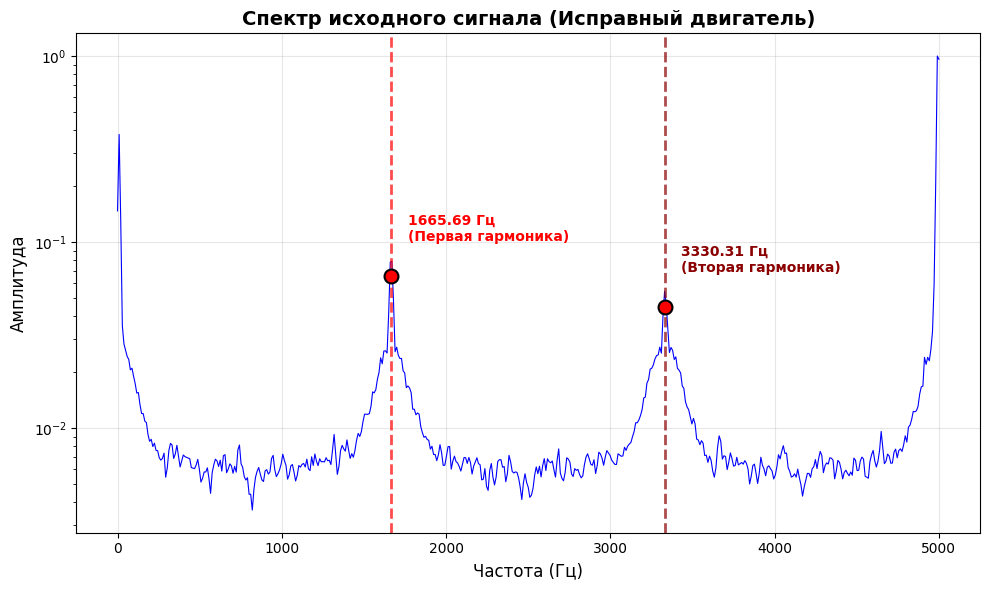

In [43]:
# Создание графика спектра оригинального сигнала для статьи
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Получаем спектр оригинального сигнала (здоровый)
h_spectrum = analyzer.compute_fft_spectrum(h_stages['original'], 'original', nperseg=1024)
h_freqs = h_spectrum['freqs']
h_magnitude = h_spectrum['magnitude']

# Ограничиваем частотный диапазон до 5000 Гц
freq_limit = 5000
freq_mask = h_freqs <= freq_limit

# Строим спектр
ax.plot(h_freqs[freq_mask], h_magnitude[freq_mask], 'b-', linewidth=0.8)
ax.set_title('Спектр исходного сигнала (Исправный двигатель)', fontsize=14, fontweight='bold')
ax.set_xlabel('Частота (Гц)', fontsize=12)
ax.set_ylabel('Амплитуда', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Добавляем вертикальные линии на частотах пиков
peak1_freq = 1665.69
peak1_mag = 0.065343
peak2_freq = 3330.31
peak2_mag = 0.044576

ax.axvline(x=peak1_freq, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.axvline(x=peak2_freq, color='darkred', linestyle='--', linewidth=2, alpha=0.7)

# Добавляем подписи к вертикальным линиям
ax.text(peak1_freq + 100, peak1_mag * 1.5, f'{peak1_freq:.2f} Гц\n(Первая гармоника)', 
        fontsize=10, color='red', fontweight='bold', va='bottom')
ax.text(peak2_freq + 100, peak2_mag * 1.5, f'{peak2_freq:.2f} Гц\n(Вторая гармоника)', 
        fontsize=10, color='darkred', fontweight='bold', va='bottom')

# Добавляем точки на пиках
ax.scatter([peak1_freq, peak2_freq], [peak1_mag, peak2_mag], 
          color='red', s=100, zorder=5, marker='o', edgecolors='black', linewidths=1.5)

plt.tight_layout()
plt.show()

print(f"Пик 1: {peak1_freq:.2f} Гц - Первая гармоника несущей частоты")
print(f"Пик 2: {peak2_freq:.2f} Гц - Вторая гармоника несущей частоты")


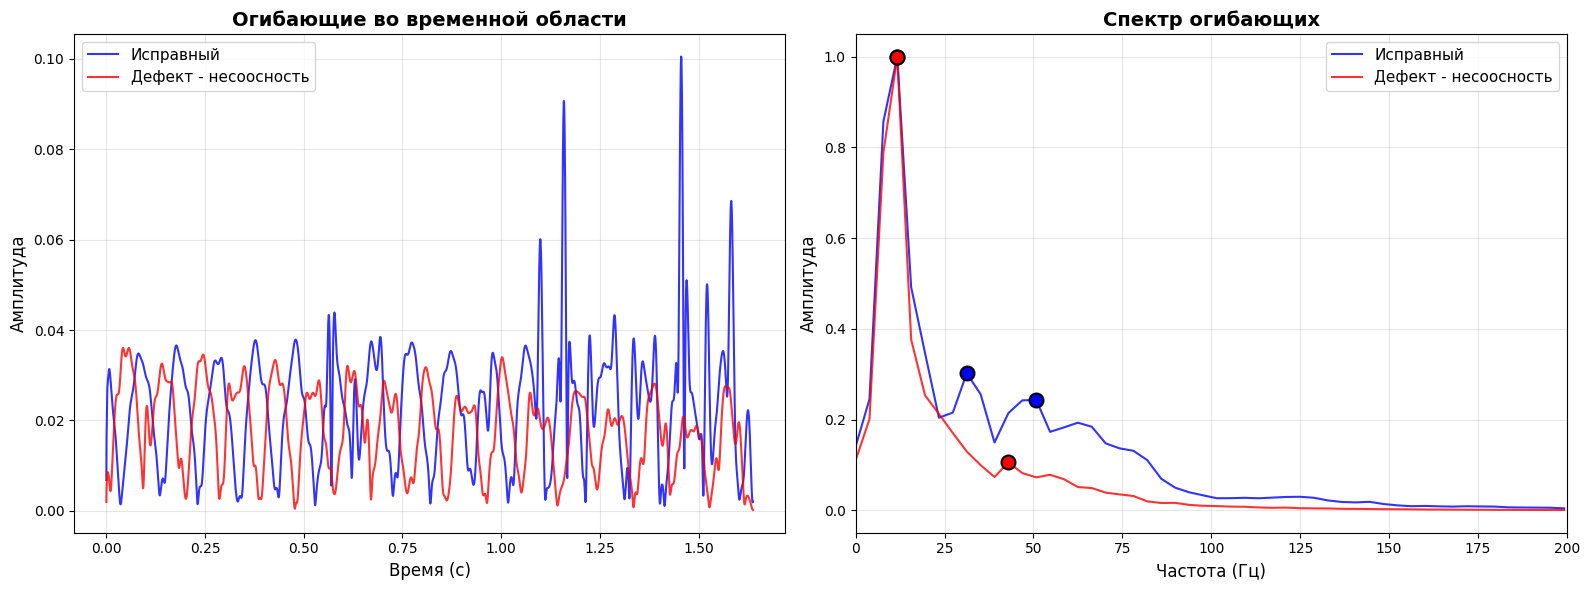

In [44]:
# Сравнение огибающих: временная область и спектр
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#fig.suptitle('Сравнение огибающих: исправный и неисправный двигатель', fontsize=16, fontweight='bold')

# Левый график: Сравнение огибающих во временной области
h_envelope = h_stages['envelope_decimated']
f_envelope = f_stages['envelope_decimated']

time_h = np.arange(len(h_envelope)) / env_conf.envelope_fs
time_f = np.arange(len(f_envelope)) / env_conf.envelope_fs

axes[0].plot(time_h, h_envelope, 'b-', label='Исправный', alpha=0.8, linewidth=1.5)
axes[0].plot(time_f, f_envelope, 'r-', label='Дефект - несоосность', alpha=0.8, linewidth=1.5)
axes[0].set_title('Огибающие во временной области', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Время (с)', fontsize=12)
axes[0].set_ylabel('Амплитуда', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Правый график: Сравнение спектров огибающих
h_spectrum = analyzer.compute_fft_spectrum(h_stages['original'], 'envelope_decimated', nperseg=512)
f_spectrum = analyzer.compute_fft_spectrum(f_stages['original'], 'envelope_decimated', nperseg=512)

# Ограничиваем частотный диапазон до 200 Гц
freq_limit = 200
h_freq_mask = h_spectrum['freqs'] <= freq_limit
f_freq_mask = f_spectrum['freqs'] <= freq_limit

axes[1].plot(h_spectrum['freqs'][h_freq_mask], h_spectrum['magnitude'][h_freq_mask], 
            'b-', linewidth=1.5, label='Исправный', alpha=0.8)
axes[1].plot(f_spectrum['freqs'][f_freq_mask], f_spectrum['magnitude'][f_freq_mask], 
            'r-', linewidth=1.5, label='Дефект - несоосность', alpha=0.8)
axes[1].set_title('Спектр огибающих', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Частота (Гц)', fontsize=12)
axes[1].set_ylabel('Амплитуда', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 200)

# Добавляем детектирование пиков для визуализации
peak_cutoff = 200
cutoff_idx_h = np.where(h_spectrum['freqs'] <= peak_cutoff)[0][-1] if len(np.where(h_spectrum['freqs'] <= peak_cutoff)[0]) > 0 else len(h_spectrum['freqs'])//2
cutoff_idx_f = np.where(f_spectrum['freqs'] <= peak_cutoff)[0][-1] if len(np.where(f_spectrum['freqs'] <= peak_cutoff)[0]) > 0 else len(f_spectrum['freqs'])//2
h_median = np.median(h_spectrum['magnitude'][:cutoff_idx_h])
f_median = np.median(f_spectrum['magnitude'][:cutoff_idx_f])

h_peaks = analyzer.find_spectral_peaks(h_spectrum, num_peaks=5, distance=2, prominence=h_median, height=h_median*2)
f_peaks = analyzer.find_spectral_peaks(f_spectrum, num_peaks=5, distance=2, prominence=f_median, height=f_median*2)

if len(h_peaks['peak_freqs']) > 0:
    axes[1].scatter(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'], 
                   color='blue', s=100, zorder=5, marker='o', edgecolors='black', linewidths=1.5)
if len(f_peaks['peak_freqs']) > 0:
    axes[1].scatter(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'], 
                   color='red', s=100, zorder=5, marker='o', edgecolors='black', linewidths=1.5)

plt.tight_layout()
plt.show()

print("Сравнительный анализ огибающих:")
print("="*50)
print(f"\nИсправный двигатель - обнаружено пиков: {len(h_peaks['peak_freqs'])}")
if len(h_peaks['peak_freqs']) > 0:
    for i, (freq, mag) in enumerate(zip(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'])):
        print(f"  Пик {i+1}: {freq:.2f} Гц, амплитуда: {mag:.6f}")

print(f"\nНеисправный двигатель - обнаружено пиков: {len(f_peaks['peak_freqs'])}")
if len(f_peaks['peak_freqs']) > 0:
    for i, (freq, mag) in enumerate(zip(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'])):
        print(f"  Пик {i+1}: {freq:.2f} Гц, амплитуда: {mag:.6f}")


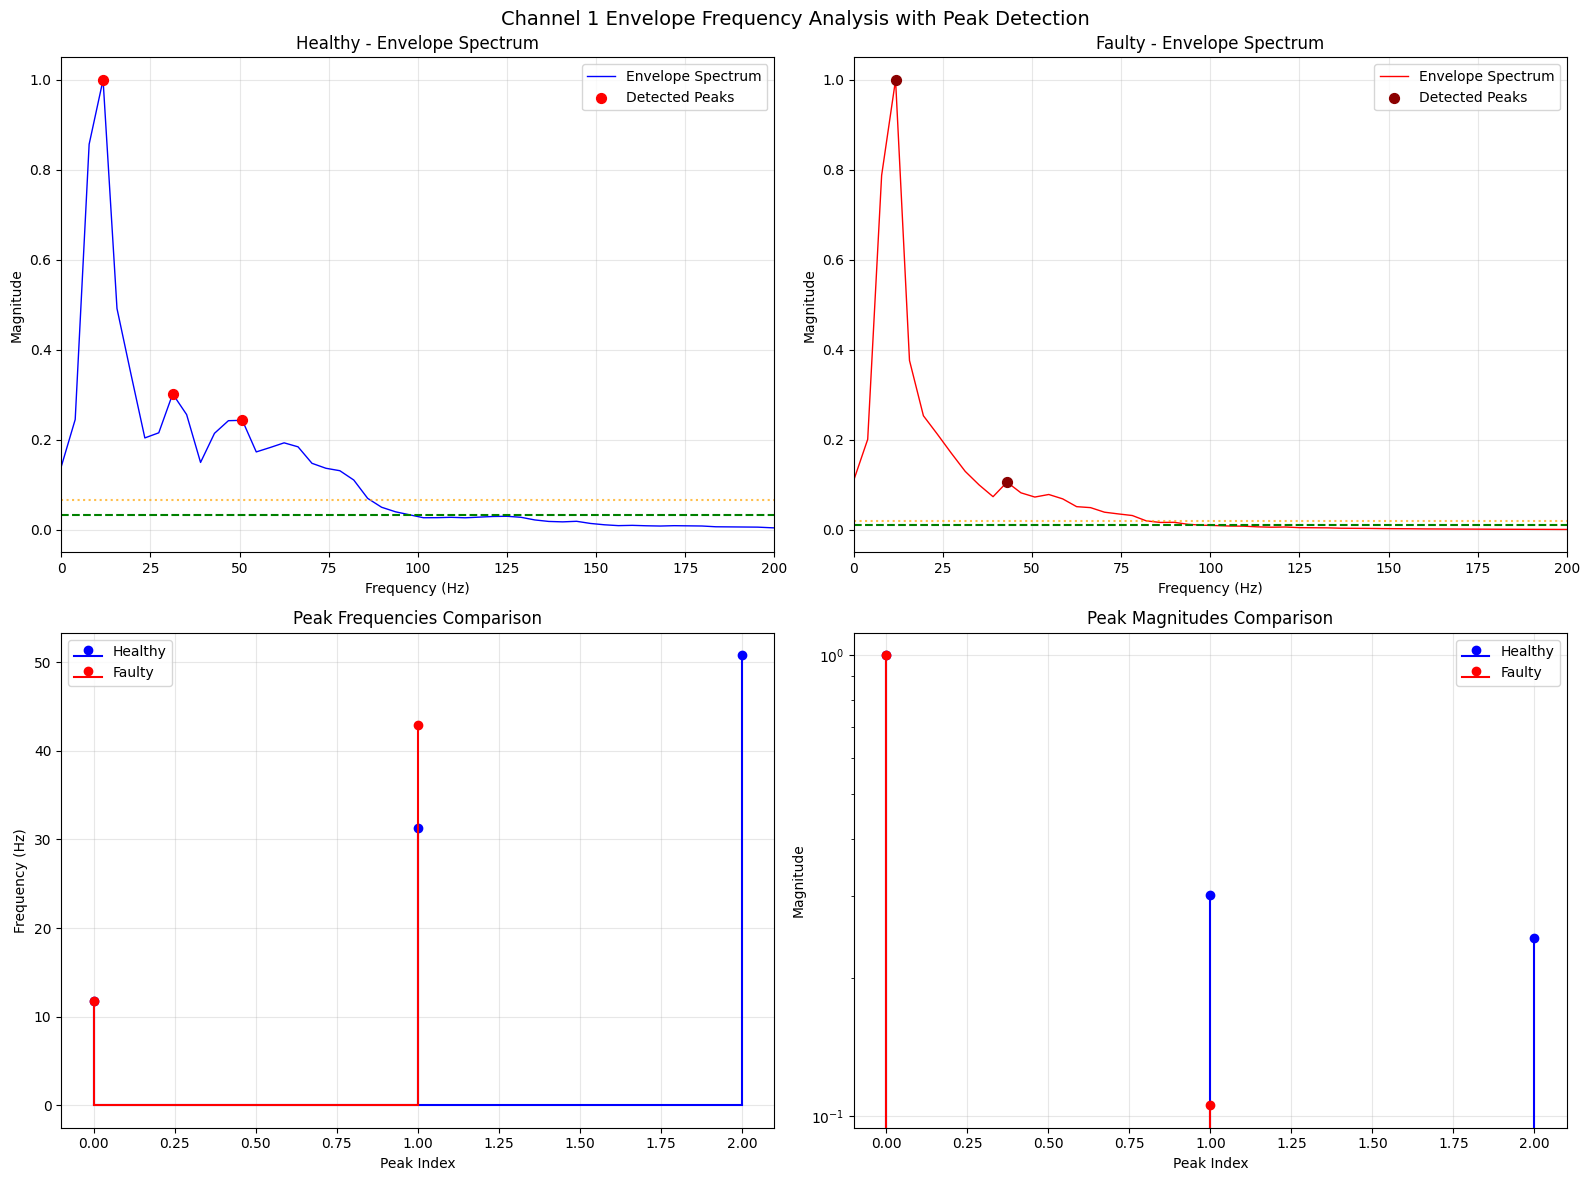

In [45]:
# Detailed frequency analysis with peak detection
def plot_envelope_frequency_analysis(stages_healthy, stages_faulty, analyzer, title_prefix=""):
    """Detailed frequency analysis of envelope with peak detection"""
    
    # Get envelope spectra
    h_spectrum = analyzer.compute_fft_spectrum(stages_healthy['original'], 'envelope_decimated', nperseg=512)
    f_spectrum = analyzer.compute_fft_spectrum(stages_faulty['original'], 'envelope_decimated', nperseg=512)

    # Find peaks 
    peak_cutoff = 200  # Hz
    cutoff_idx_h = np.where(h_spectrum['freqs'] <= peak_cutoff)[0][-1] if len(np.where(h_spectrum['freqs'] <= peak_cutoff)[0]) > 0 else len(h_spectrum['freqs'])//2
    cutoff_idx_f = np.where(f_spectrum['freqs'] <= peak_cutoff)[0][-1] if len(np.where(f_spectrum['freqs'] <= peak_cutoff)[0]) > 0 else len(f_spectrum['freqs'])//2
    h_median = np.median(h_spectrum['magnitude'][:cutoff_idx_h])
    f_median = np.median(f_spectrum['magnitude'][:cutoff_idx_f])

    h_peaks = analyzer.find_spectral_peaks(h_spectrum, num_peaks=10, distance=2, prominence=h_median, height=h_median*2)
    f_peaks = analyzer.find_spectral_peaks(f_spectrum, num_peaks=10, distance=2, prominence=f_median, height=f_median*2)

    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{title_prefix} Envelope Frequency Analysis with Peak Detection', fontsize=14)
    
    # Healthy envelope spectrum
    axes[0, 0].plot(h_spectrum['freqs'], h_spectrum['magnitude'], 'b-', linewidth=1, label='Envelope Spectrum')
    if len(h_peaks['peak_freqs']) > 0:
        axes[0, 0].scatter(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'], 
                          color='red', s=50, zorder=5, label='Detected Peaks')
    axes[0, 0].set_title('Healthy - Envelope Spectrum')
    axes[0, 0].set_xlabel('Frequency (Hz)')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    axes[0, 0].set_xlim(0, 200) 
    axes[0, 0].axhline(y=h_median, color='g', linestyle='--')
    axes[0, 0].axhline(y=h_median*2, color='orange', linestyle=':', alpha=0.7)

    # Faulty envelope spectrum
    axes[0, 1].plot(f_spectrum['freqs'], f_spectrum['magnitude'], 'r-', linewidth=1, label='Envelope Spectrum')
    if len(f_peaks['peak_freqs']) > 0:
        axes[0, 1].scatter(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'], 
                          color='darkred', s=50, zorder=5, label='Detected Peaks')
    axes[0, 1].set_title('Faulty - Envelope Spectrum')
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    axes[0, 1].set_xlim(0, 200)
    axes[0, 1].axhline(y=f_median, color='g', linestyle='--')
    axes[0, 1].axhline(y=f_median*2, color='orange', linestyle=':', alpha=0.7)
    
    # Comparison of peak frequencies - handle case where no peaks found
    if len(h_peaks['peak_freqs']) > 0:
        axes[1, 0].stem(range(len(h_peaks['peak_freqs'])), h_peaks['peak_freqs'], 
                       basefmt='b-', linefmt='b-', markerfmt='bo', label='Healthy')
    if len(f_peaks['peak_freqs']) > 0:
        axes[1, 0].stem(range(len(f_peaks['peak_freqs'])), f_peaks['peak_freqs'], 
                       basefmt='r-', linefmt='r-', markerfmt='ro', label='Faulty')
    
    if len(h_peaks['peak_freqs']) == 0 and len(f_peaks['peak_freqs']) == 0:
        axes[1, 0].text(0.5, 0.5, 'No peaks detected', ha='center', va='center', 
                       transform=axes[1, 0].transAxes, fontsize=12)
    
    axes[1, 0].set_title('Peak Frequencies Comparison')
    axes[1, 0].set_xlabel('Peak Index')
    axes[1, 0].set_ylabel('Frequency (Hz)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Comparison of peak magnitudes - handle case where no peaks found
    if len(h_peaks['peak_magnitudes']) > 0:
        axes[1, 1].stem(range(len(h_peaks['peak_magnitudes'])), h_peaks['peak_magnitudes'], 
                       basefmt='b-', linefmt='b-', markerfmt='bo', label='Healthy')
    if len(f_peaks['peak_magnitudes']) > 0:
        axes[1, 1].stem(range(len(f_peaks['peak_magnitudes'])), f_peaks['peak_magnitudes'], 
                       basefmt='r-', linefmt='r-', markerfmt='ro', label='Faulty')
    
    if len(h_peaks['peak_magnitudes']) == 0 and len(f_peaks['peak_magnitudes']) == 0:
        axes[1, 1].text(0.5, 0.5, 'No peaks detected', ha='center', va='center', 
                       transform=axes[1, 1].transAxes, fontsize=12)
    else:
        axes[1, 1].set_yscale('log')
    
    axes[1, 1].set_title('Peak Magnitudes Comparison')
    axes[1, 1].set_xlabel('Peak Index')
    axes[1, 1].set_ylabel('Magnitude')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print peak information
    print(f"\n{title_prefix} - Peak Analysis:")
    print("="*50)
    
    if len(h_peaks['peak_freqs']) > 0:
        print("\nHealthy Envelope Peaks:")
        for i, (freq, mag) in enumerate(zip(h_peaks['peak_freqs'], h_peaks['peak_magnitudes'])):
            print(f"  Peak {i+1}: {freq:.2f} Hz, magnitude: {mag:.6f}")
    else:
        print("\nHealthy Envelope: No peaks detected with current parameters")
    
    if len(f_peaks['peak_freqs']) > 0:
        print("\nFaulty Envelope Peaks:")
        for i, (freq, mag) in enumerate(zip(f_peaks['peak_freqs'], f_peaks['peak_magnitudes'])):
            print(f"  Peak {i+1}: {freq:.2f} Hz, magnitude: {mag:.6f}")
    else:
        print("\nFaulty Envelope: No peaks detected with current parameters")
    
    # Print some spectrum statistics
    print(f"\nSpectrum Statistics:")
    print(f"Healthy - Max magnitude: {np.max(h_spectrum['magnitude']):.6f}, Mean: {np.mean(h_spectrum['magnitude']):.6f}")
    print(f"Faulty  - Max magnitude: {np.max(f_spectrum['magnitude']):.6f}, Mean: {np.mean(f_spectrum['magnitude']):.6f}")
    
    return fig, {'spectrum': h_spectrum, 'peaks': h_peaks}, {'spectrum': f_spectrum, 'peaks': f_peaks}

# Run the detailed frequency analysis
fig_freq, h_analysis, f_analysis = plot_envelope_frequency_analysis(h_stages, f_stages, analyzer, "Channel 1")

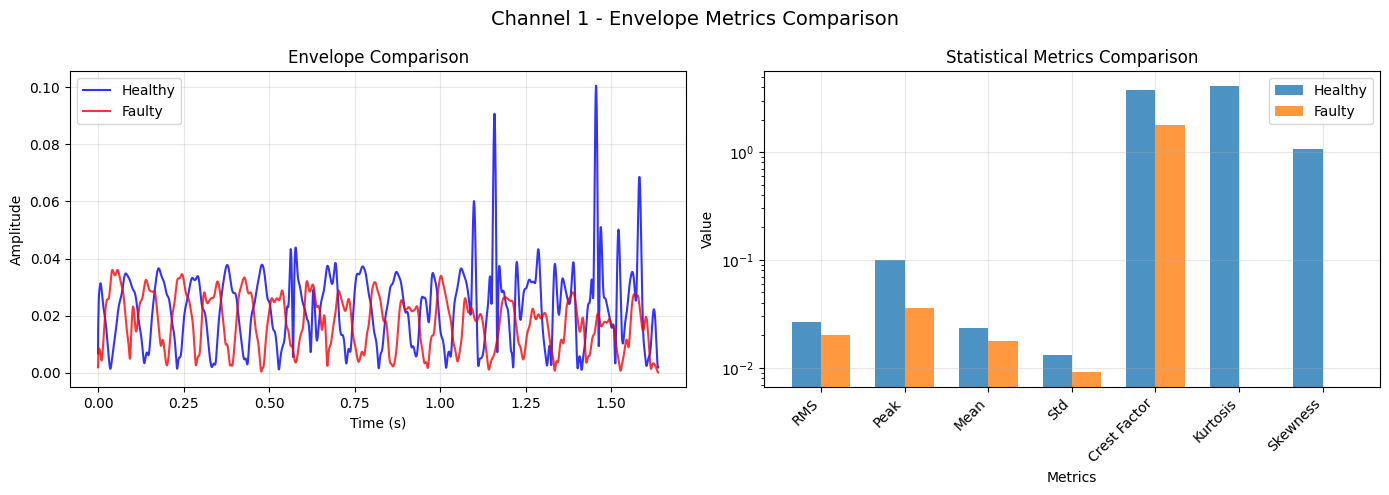

In [46]:
# Summary analysis and metrics comparison
def analyze_envelope_metrics(stages_healthy, stages_faulty, analyzer, title_prefix=""):
    """Calculate and compare envelope metrics between healthy and faulty signals"""
    
    print(f"\n{title_prefix} - Envelope Analysis Summary")
    print("="*60)
    
    # Extract final envelopes
    h_envelope = stages_healthy['envelope_decimated']
    f_envelope = stages_faulty['envelope_decimated']
    
    # Basic statistical metrics
    h_metrics = {
        'RMS': np.sqrt(np.mean(h_envelope**2)),
        'Peak': np.max(h_envelope),
        'Mean': np.mean(h_envelope),
        'Std': np.std(h_envelope),
        'Crest Factor': np.max(h_envelope) / np.sqrt(np.mean(h_envelope**2)),
        'Kurtosis': np.mean(((h_envelope - np.mean(h_envelope)) / np.std(h_envelope))**4) - 3,
        'Skewness': np.mean(((h_envelope - np.mean(h_envelope)) / np.std(h_envelope))**3)
    }
    
    f_metrics = {
        'RMS': np.sqrt(np.mean(f_envelope**2)),
        'Peak': np.max(f_envelope),
        'Mean': np.mean(f_envelope),
        'Std': np.std(f_envelope),
        'Crest Factor': np.max(f_envelope) / np.sqrt(np.mean(f_envelope**2)),
        'Kurtosis': np.mean(((f_envelope - np.mean(f_envelope)) / np.std(f_envelope))**4) - 3,
        'Skewness': np.mean(((f_envelope - np.mean(f_envelope)) / np.std(f_envelope))**3)
    }
    
    # Print comparison table
    print(f"\n{'Metric':<15} {'Healthy':<12} {'Faulty':<12} {'Ratio (F/H)':<12} {'Diff %':<10}")
    print("-" * 70)
    
    for metric in h_metrics.keys():
        h_val = h_metrics[metric]
        f_val = f_metrics[metric]
        ratio = f_val / h_val if h_val != 0 else float('inf')
        diff_pct = ((f_val - h_val) / h_val * 100) if h_val != 0 else float('inf')
        
        print(f"{metric:<15} {h_val:<12.6f} {f_val:<12.6f} {ratio:<12.2f} {diff_pct:<10.1f}%")
    
    # Create comparison visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{title_prefix} - Envelope Metrics Comparison', fontsize=14)
    
    # Envelope comparison
    time_h = np.arange(len(h_envelope)) / analyzer.config.envelope_fs
    time_f = np.arange(len(f_envelope)) / analyzer.config.envelope_fs
    
    axes[0].plot(time_h, h_envelope, 'b-', label='Healthy', alpha=0.8)
    axes[0].plot(time_f, f_envelope, 'r-', label='Faulty', alpha=0.8)
    axes[0].set_title('Envelope Comparison')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Statistical metrics comparison
    metrics_names = list(h_metrics.keys())
    h_values = list(h_metrics.values())
    f_values = list(f_metrics.values())
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    axes[1].bar(x - width/2, h_values, width, label='Healthy', alpha=0.8)
    axes[1].bar(x + width/2, f_values, width, label='Faulty', alpha=0.8)
    axes[1].set_title('Statistical Metrics Comparison')
    axes[1].set_xlabel('Metrics')
    axes[1].set_ylabel('Value')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(metrics_names, rotation=45, ha='right')
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return h_metrics, f_metrics, 

# Run comprehensive analysis
h_metrics, f_metrics= analyze_envelope_metrics(h_stages, f_stages, analyzer, "Channel 1")